<a href="https://colab.research.google.com/github/ssktotoro/neuro/blob/tutorial_branch/Neuro_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Authors: [Kevin Wang](https://github.com/ssktotoro/), [Alex Fedorov](https://github.com/Entodi/), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `\"Python 3\"` and `\"GPU\"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.

In [ ]:
%%bash 
git clone https://github.com/ssktotoro/neuro.git -b tutorial_branch
pip install -r neuro/requirements/requirements.txt

In [19]:
import torch
import nibabel as nib
from catalyst.metrics.functional._segmentation import dice
import matplotlib.pyplot as plt

%matplotlib inline

from infer import Predictor
from training.model import MeshNet, UNet

In [31]:
volume_shape = [256, 256, 256]
subvolume_shape = [38, 38, 38]
n_subvolumes = 512
n_classes = 31
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
meshnet_model = MeshNet(n_channels=1, n_classes=n_classes)
meshnet_model.load_state_dict(torch.load('training/logs/meshnet_mindboggle/train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_predictor = Predictor(model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

unet_model = UNet(n_channels=1, n_classes=n_classes)
unet_model.load_state_dict(torch.load('training/logs/unet_mindboggle/train.30_full.pth', map_location=device)['model_state_dict'])
unet_predictor = Predictor(model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

atlas_classes = 104
meshnet_hcp_model = MeshNet(n_channels=1, n_classes=atlas_classes)
meshnet_hcp_model.load_state_dict(torch.load('training/logs/meshnet_hcp/train.28_full.pth', map_location=device)['model_state_dict'])
meshnet_hcp_predictor = Predictor(meshnet_hcp_model, volume_shape, subvolume_shape, n_subvolumes, atlas_classes)

In [21]:
%time meshnet_predicted_segmentation = meshnet_predictor.predict('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')

CPU times: user 31min 30s, sys: 41.8 s, total: 32min 12s
Wall time: 1min 7s


In [22]:
%time unet_predicted_segmentation = unet_predictor.predict('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')

CPU times: user 32min 2s, sys: 41.8 s, total: 32min 44s
Wall time: 1min 8s


In [32]:
%time meshnet_atlas_predicted_segmentation = meshnet_hcp_predictor.predict('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')

CPU times: user 38min 1s, sys: 9.61 s, total: 38min 10s
Wall time: 1min 17s


In [15]:
img = nib.load('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')
img = img.get_fdata()

labels = nib.load('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/labels.DKT31.manual+aseg_labels.nii.gz')
labels = labels.get_fdata()

In [17]:
inference_dice = dice(                                                                                                                                                                            
  torch.nn.functional.one_hot(                                                                                                                                                                  
      predicted_segmentation, n_classes).permute(0, 3, 1, 2),                                                                                                                              
  torch.nn.functional.one_hot(                                                                                                                                                                  
      torch.from_numpy(labels).to(torch.int64), n_classes).permute(0, 3, 1, 2)).detach().numpy()
print(inference_dice)

[0.99916685 0.7521031  0.74848247 0.62878424 0.7521994  0.8028825
 0.85423577 0.8465837  0.6374767  0.80046207 0.8486501  0.75603217
 0.6690141  0.8527329  0.821192   0.71862864 0.77149475 0.8454925
 0.8047154  0.58311623 0.7915557  0.78008837 0.7708557  0.74839866
 0.80350935 0.8133509  0.839046   0.77831596 0.8353709  0.8029096
 0.8877402 ]


In [49]:
def show_slices(slices, raw=True):
    if raw:
        cmap = 'jet'
    else:
        cmap = 'nipy_spectral'
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='nipy_spectral')

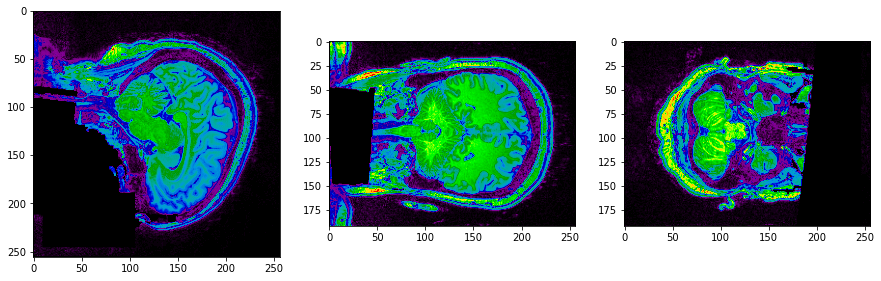

In [51]:
show_slices(
    [img[100, :,:], 
     img[:, 100,:], 
     img[:, :, 100]
     ])

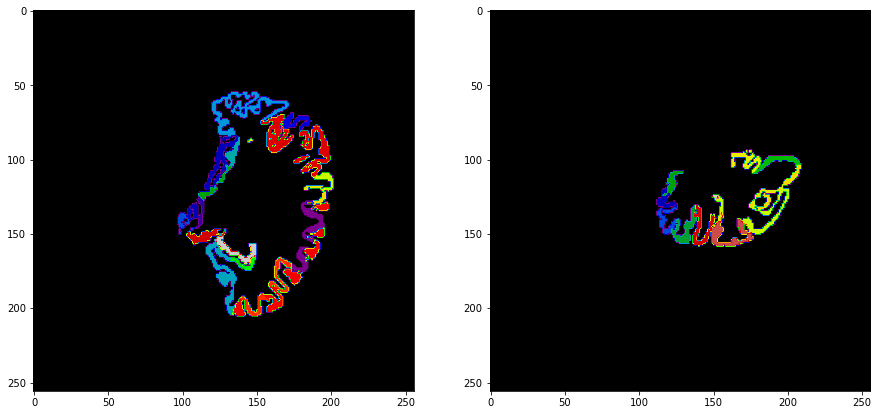

In [52]:
show_slices(
    [labels[120, :,:], 
     labels[:, 120,:], 
     ], raw=False)

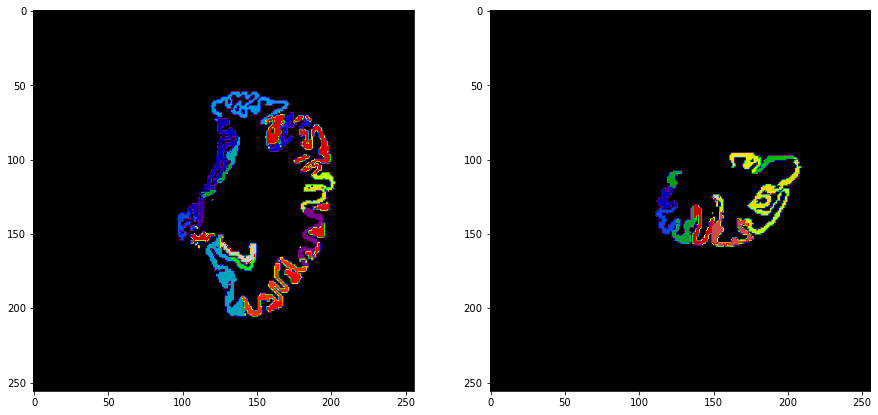

In [44]:
show_slices(
    [predicted_segmentation[120, :,:], 
     predicted_segmentation[:, 120,:], 
     ], raw=False)

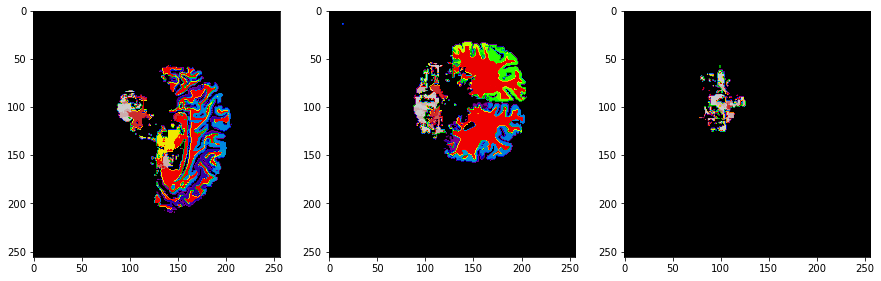

In [50]:
show_slices(
    [meshnet_atlas_predicted_segmentation[100, :,:], 
     meshnet_atlas_predicted_segmentation[:, 100,:],
     meshnet_atlas_predicted_segmentation[:, :, 100]],
    raw=False)